In [1]:
from resnet import Resnet
from dataset import *
from torch.utils.data import DataLoader
import torch

In [2]:
model = Resnet(19)

In [73]:
import os
import re
from abc import ABC

import cv2
import numpy as np
from torch.utils.data import Dataset
from tqdm import tqdm


class ImageDataset(Dataset):
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    def __init__(self, path: str, width: int, height: int):
        self.width = width
        self.height = height
        self.path = path
        self.dataset_meta = self.define_dataset_meta()
        self.image_paths = self.parse_file(path) or None
        self.image_keys = list(self.image_paths.keys())
        self.image_classes = list(self.image_paths.values())

    def parse_file(self, path: str):
        if not os.path.exists(path):
            raise ValueError("Provided path doesn't exist")

        with open(os.path.join(path, self.dataset_meta), "r") as f:
            lines = f.readlines()

        paths = {}
        for line in lines:
            s = re.split(r'\t+', line.rstrip().rstrip('\t'))
            paths[s[0]] = s[1]

        return paths

    def calculate_stats(self):
        """
        Calculate the mean and standard deviation per channel over the entire dataset.
        THIS METHOD DOESN'T SAVE THE STATS
        BE CAREFULLY, THIS IS DANGEROUS CODE
        """

        train_stacked = []
        for k in tqdm(range(len(self.image_keys)), "Reading images"):
            arr = self[k]
            train_stacked.append(arr)

        train_stacked = np.stack(train_stacked)
        means = [np.mean(train_stacked[:, :, :, i]) for i in range(2)]
        stds = [np.std(train_stacked[:, :, :, i]) for i in range(2)]

        print("Mean per channel: ", means)
        print("Standard deviation per channel: ", stds)

    def __len__(self):
        if self.image_paths:
            return len(self.image_paths.keys())
        raise Exception("There is no data!")

    def smart_resize(self, arr):
        ratio = self.width / min(arr.shape[:2])
        new_width = arr.shape[0] * ratio
        new_height = arr.shape[1] * ratio
        arr_resized = cv2.resize(arr, dsize=(int(new_height), int(new_width)))
        if arr_resized.shape[1] > arr_resized.shape[0]:
            diff = arr_resized.shape[1] - self.width
            half = int(diff / 2)
            arr_cropped = arr_resized[:, half: half + self.width]
        else:
            diff = arr_resized.shape[0] - self.width
            half = int(diff / 2)
            arr_cropped = arr_resized[half: half + self.width, :]
        return arr_cropped

    def __getitem__(self, index: int):

        assert index < len(self), f"Index must be less or equal to {len(self) - 1}"

        arr = cv2.imread(os.path.join(self.path, self.image_keys[index]), cv2.IMREAD_COLOR)
        arr = self.smart_resize(arr)
        # arr = cv2.resize(arr, dsize=(self.width, self.height))
        arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB) / 255.0
        plt.imshow(arr)
        for c in range(2):
            arr[:, :, c] = (arr[:, :, c] - self.MEAN[c]) / self.STD[c]
        
        arr = np.swapaxes(arr, 0, -1)
        arr = arr.astype(np.float32)

        return arr, float(self.image_classes[index])

    def define_dataset_meta(self):
        raise NotImplementedError


class TrainImageDataset(ImageDataset):

    def __init__(self, path: str, width: int, height: int):
        super(TrainImageDataset, self).__init__(path, width, height)

    def define_dataset_meta(self):
        return "train_sample.txt"


In [74]:
train_dataset = TrainImageDataset("/home/rudy/Documents/cc7221/tarea1/data/clothing-small", 224, 224)

(3, 224, 224)


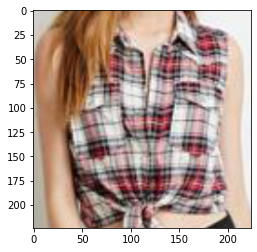

In [75]:
e = train_dataset[0]
print(e[0].shape)

In [52]:
import matplotlib.pyplot as plt
arr = cv2.imread("/home/rudy/Documents/cc7221/tarea1/data/clothing-small/test_sample/1fb06ea6-a5dc-4ee2-a.png", cv2.IMREAD_COLOR)
arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)

In [59]:
e[0]

array([[[ 1.6324172 ,  1.6324172 ,  1.6263776 , ...,  0.9131775 ,
          0.9131775 ,  0.9131775 ],
        [ 1.6324172 ,  1.6324172 ,  1.6263776 , ...,  0.9131775 ,
          0.9131775 ,  0.9131775 ],
        [ 1.6324172 ,  1.6324172 ,  1.6263776 , ...,  0.9131775 ,
          0.9131775 ,  0.9131775 ],
        ...,
        [ 2.0262866 ,  2.0262866 ,  2.0262866 , ..., -1.1894512 ,
         -1.2231287 , -1.3362812 ],
        [ 2.0262866 ,  2.0262866 ,  2.0262866 , ..., -1.1133564 ,
         -1.1583785 , -1.2995853 ],
        [ 2.0262866 ,  2.0262866 ,  2.0262866 , ..., -1.070236  ,
         -1.1216867 , -1.278791  ]],

       [[ 1.7808124 ,  1.7808124 ,  1.7746379 , ...,  0.9754902 ,
          0.9754902 ,  0.9754902 ],
        [ 1.7808124 ,  1.7808124 ,  1.7746379 , ...,  0.9754902 ,
          0.9754902 ,  0.9754902 ],
        [ 1.7808124 ,  1.7808124 ,  1.7746379 , ...,  0.9754902 ,
          0.9754902 ,  0.9754902 ],
        ...,
        [ 2.2009804 ,  2.2009804 ,  2.2009804 , ..., -

(304, 226, 3)


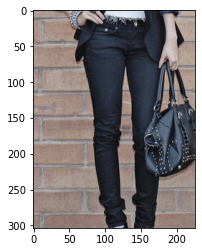

In [54]:
plt.imshow(arr)
print(arr.shape)

0.9911504424778761
(304, 226, 3)
(362, 224, 3)
(224, 224, 3)


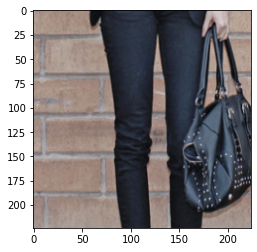

In [55]:
plt.imshow(smart_resize(arr))